### Credit Card Segmentation

### Business Problem:

This case requires trainees to develop a customer segmentation to define marketing strategy. The sample dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

### Importing Neceesary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install pandas_profiling 
import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import sklearn as sk

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

### Importing Dataset

In [4]:
credit_card = pd.read_csv('CC_GENERAL.csv')

In [5]:
credit_card.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Data Audit

In [6]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [7]:
#CUST_ID can be dropped as it is not of much use for analysis
credit_card.drop(columns='CUST_ID',inplace=True)

In [8]:
numerical_vars = credit_card.select_dtypes(['float64','int64'])
numerical_vars.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [9]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [10]:
#Data Summary
numerical_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.400205e+07,1564.474828,873.385231,2081.531879,4.332775e+06,0.000000,0.065101,8.814518,23.575529,128.281915,873.385231,2054.140036,4338.563657,5909.111808,9338.804814,19043.13856
BALANCE_FREQUENCY,8950.0,0.0,7.851573e+03,0.877271,1.000000,0.236904,5.612351e-02,0.000000,0.090909,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
PURCHASES,8950.0,0.0,8.978683e+06,1003.204834,361.280000,2136.634782,4.565208e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3998.619500,8977.290000,49039.57000
ONEOFF_PURCHASES,8950.0,0.0,5.302314e+06,592.437371,38.000000,1659.887917,2.755228e+06,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2671.094000,6689.898200,40761.25000
INSTALLMENTS_PURCHASES,8950.0,0.0,3.679055e+06,411.067645,89.000000,904.338115,8.178274e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1750.087500,3886.240500,22500.00000
CASH_ADVANCE,8950.0,0.0,8.760896e+06,978.871112,0.000000,2097.163877,4.398096e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4647.169122,9588.163357,47137.21176
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.209541e+03,0.135144,0.000000,0.200121,4.004857e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.833333,1.50000


In [11]:
categorical_vars = credit_card.select_dtypes(['object', 'O'])
categorical_vars.head(1)

""
0


### Advanced Data Preparation

Build an ‘enriched’ customer profile by deriving “intelligent” KPIs

#### Deriving new KPIs

In [12]:
credit_card['Monthly_Avg_Purchase'] = credit_card.PURCHASES/credit_card.TENURE

In [13]:
credit_card.Monthly_Avg_Purchase.head()

0      7.950000
1      0.000000
2     64.430833
3    124.916667
4      1.333333
Name: Monthly_Avg_Purchase, dtype: float64

In [14]:
credit_card['Monthly_Cash_Advance'] = credit_card.CASH_ADVANCE/credit_card.TENURE

In [15]:
credit_card.Monthly_Cash_Advance.head()

0      0.000000
1    536.912124
2      0.000000
3     17.149001
4      0.000000
Name: Monthly_Cash_Advance, dtype: float64

In [16]:
credit_card['limit_usage'] = credit_card.BALANCE/credit_card.CREDIT_LIMIT

In [17]:
credit_card.limit_usage.head()

0    0.040901
1    0.457495
2    0.332687
3    0.222223
4    0.681429
Name: limit_usage, dtype: float64

In [18]:
credit_card['payment_ratio'] = credit_card.PAYMENTS/credit_card.MINIMUM_PAYMENTS

In [19]:
credit_card.payment_ratio.head()

0    1.446508
1    3.826241
2    0.991682
3         NaN
4    2.771075
Name: payment_ratio, dtype: float64

In [20]:
credit_card['purchase_type']=np.where((credit_card['INSTALLMENTS_PURCHASES']>0) & (credit_card['ONEOFF_PURCHASES']==0),'Installment_Puchases',
                                        np.where((credit_card['INSTALLMENTS_PURCHASES']==0) & (credit_card['ONEOFF_PURCHASES']>0),'One_Of',
                                               np.where((credit_card['INSTALLMENTS_PURCHASES']>0) & (credit_card['ONEOFF_PURCHASES']>0),'Both','None')))

In [21]:
credit_card.purchase_type.head()

0    Installment_Puchases
1                    None
2                  One_Of
3                  One_Of
4                  One_Of
Name: purchase_type, dtype: object

From above KPI we can observe that there are 4 types of purchase behaviour in the data set.

- Customers who do 'One-Of' Purchases
- Customers who do 'Installment' Purchases
- Customers who do 'Both' type of Purchases
- Customers who use 'None' of the type of Purchases or we can say they don't use credit card for Purchases

### Exploratory Data Analysis

In [22]:
numerical_vars = credit_card.select_dtypes(['float64','int64'])
numerical_vars.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_Avg_Purchase,Monthly_Cash_Advance,limit_usage,payment_ratio
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,2,1000.0,201.802084,139.509787,0.000000,12,7.950000,0.000000,0.040901,1.446508
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,536.912124,0.457495,3.826241
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,12,7500.0,622.066742,627.284787,0.000000,12,64.430833,0.000000,0.332687,0.991682
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,1,7500.0,0.000000,NaN,0.000000,12,124.916667,17.149001,0.222223,NaN
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,1,1200.0,678.334763,244.791237,0.000000,12,1.333333,0.000000,0.681429,2.771075


In [23]:
# Data Summary
numerical_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.400205e+07,1564.474828,873.385231,2081.531879,4.332775e+06,0.000000,0.065101,8.814518,23.575529,128.281915,873.385231,2054.140036,4338.563657,5909.111808,9338.804814,19043.138560
BALANCE_FREQUENCY,8950.0,0.0,7.851573e+03,0.877271,1.000000,0.236904,5.612351e-02,0.000000,0.090909,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PURCHASES,8950.0,0.0,8.978683e+06,1003.204834,361.280000,2136.634782,4.565208e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3998.619500,8977.290000,49039.570000
ONEOFF_PURCHASES,8950.0,0.0,5.302314e+06,592.437371,38.000000,1659.887917,2.755228e+06,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2671.094000,6689.898200,40761.250000
INSTALLMENTS_PURCHASES,8950.0,0.0,3.679055e+06,411.067645,89.000000,904.338115,8.178274e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1750.087500,3886.240500,22500.000000
CASH_ADVANCE,8950.0,0.0,8.760896e+06,978.871112,0.000000,2097.163877,4.398096e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4647.169122,9588.163357,47137.211760
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.000000
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.209541e+03,0.135144,0.000000,0.200121,4.004857e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.833333,1.500000


In [24]:
writer = pd.ExcelWriter('Customer_Segmentation_Final_Output.xlsx', engine = 'xlsxwriter')

In [25]:
data_summary = numerical_vars.apply(continuous_var_summary).T
data_summary.to_excel(writer, sheet_name = 'Num_Data_Summary', index=True)

### Oulier Treatment

In [26]:
numerical_vars = numerical_vars.apply(lambda x: x.clip(lower = x.quantile(0.05), upper = x.quantile(0.95)))

In [27]:
numerical_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.299898e+07,1452.399593,873.385231,1688.929294,2.852482e+06,8.814518,8.814518,8.817256,23.575529,128.281915,873.385231,2054.140036,4338.563657,5907.794710,5909.111808,5909.111808
BALANCE_FREQUENCY,8950.0,0.0,7.905106e+03,0.883252,1.000000,0.218438,4.771536e-02,0.272727,0.272727,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PURCHASES,8950.0,0.0,7.373574e+06,823.863022,361.280000,1099.813081,1.209589e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3997.904225,3998.619500,3998.619500
ONEOFF_PURCHASES,8950.0,0.0,4.009141e+06,447.948730,38.000000,746.133555,5.567153e+05,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2668.945700,2671.094000,2671.094000
INSTALLMENTS_PURCHASES,8950.0,0.0,3.010208e+06,336.336040,89.000000,497.830168,2.478349e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1748.441625,1750.087500,1750.087500
CASH_ADVANCE,8950.0,0.0,7.313592e+06,817.161146,0.000000,1349.178282,1.820282e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4643.580882,4647.169122,4647.169122
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.000000
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.142355e+03,0.127637,0.000000,0.176670,3.121232e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.583333,0.583333


In [28]:
numerical_vars.apply(continuous_var_summary).T.to_excel(writer, sheet_name='Outlier_Treatment', index=True)

### Missing Value Treatment

In [29]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [30]:
numerical_vars = numerical_vars.apply(missing_imputation)

In [31]:
numerical_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.299898e+07,1452.399593,873.385231,1688.929294,2.852482e+06,8.814518,8.814518,8.817256,23.575529,128.281915,873.385231,2054.140036,4338.563657,5907.794710,5909.111808,5909.111808
BALANCE_FREQUENCY,8950.0,0.0,7.905106e+03,0.883252,1.000000,0.218438,4.771536e-02,0.272727,0.272727,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PURCHASES,8950.0,0.0,7.373574e+06,823.863022,361.280000,1099.813081,1.209589e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3997.904225,3998.619500,3998.619500
ONEOFF_PURCHASES,8950.0,0.0,4.009141e+06,447.948730,38.000000,746.133555,5.567153e+05,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2668.945700,2671.094000,2671.094000
INSTALLMENTS_PURCHASES,8950.0,0.0,3.010208e+06,336.336040,89.000000,497.830168,2.478349e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1748.441625,1750.087500,1750.087500
CASH_ADVANCE,8950.0,0.0,7.313592e+06,817.161146,0.000000,1349.178282,1.820282e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4643.580882,4647.169122,4647.169122
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.000000
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.142355e+03,0.127637,0.000000,0.176670,3.121232e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.583333,0.583333


In [32]:
numerical_vars.apply(continuous_var_summary).T.to_excel(writer, sheet_name='Missing_Value_Treatment', index=True)

In [33]:
#writer.save()

In [34]:
numerical_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 21 columns):
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8950 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS                    8950 non-null float64
PRC_FULL_PAYMENT           

In [35]:
categorical_vars = credit_card.select_dtypes(['object', 'O'])
categorical_vars.head()

,purchase_type
0,Installment_Puchases
1,None
2,One_Of
3,One_Of
4,One_Of


In [36]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [37]:
categorical_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
purchase_type,8950,0,Both,2774,30.99


### Dummy Variable Creation

In [38]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = False)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [39]:
categorical_vars = credit_card[['purchase_type']]

# for c_feature in categorical_features
for c_feature in ['purchase_type']:
    categorical_vars[c_feature] = categorical_vars[c_feature].astype('category')
    categorical_vars = create_dummies(categorical_vars, c_feature)
    
categorical_vars.head()    

C:\Users\nanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of
0,0,1,0,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [40]:
credit_card_final = pd.concat([numerical_vars, categorical_vars], axis = 1)
credit_card_final.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PRC_FULL_PAYMENT,TENURE,Monthly_Avg_Purchase,Monthly_Cash_Advance,limit_usage,payment_ratio,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.000000,12,7.950000,0.000000,0.040901,1.446508,0,1,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,0.222222,12,0.000000,425.548562,0.457495,3.826241,0,0,1,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,12,64.430833,0.000000,0.332687,0.991682,0,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,12,124.916667,17.149001,0.222223,4.754748,0,0,0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.000000,12,1.333333,0.000000,0.681429,2.771075,0,0,0,1


In [41]:
credit_card_final.drop(columns=['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES', 'BALANCE', 'CASH_ADVANCE', 'PURCHASES', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'CREDIT_LIMIT', 'TENURE'],inplace=True)

In [42]:
credit_card_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 16 columns):
BALANCE_FREQUENCY                     8950 non-null float64
PURCHASES_FREQUENCY                   8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY            8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY      8950 non-null float64
CASH_ADVANCE_FREQUENCY                8950 non-null float64
CASH_ADVANCE_TRX                      8950 non-null int64
PURCHASES_TRX                         8950 non-null int64
PRC_FULL_PAYMENT                      8950 non-null float64
Monthly_Avg_Purchase                  8950 non-null float64
Monthly_Cash_Advance                  8950 non-null float64
limit_usage                           8950 non-null float64
payment_ratio                         8950 non-null float64
purchase_type_Both                    8950 non-null uint8
purchase_type_Installment_Puchases    8950 non-null uint8
purchase_type_None                    8950 non-null uint8
pur

### Correlation Matrix

In [43]:
credit_card_final.corr()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Cash_Advance,limit_usage,payment_ratio,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of
BALANCE_FREQUENCY,1.000000,0.237081,0.204411,0.184918,0.200011,0.178447,0.240389,-0.111917,0.187511,0.103147,0.456759,-0.251432,0.195141,-0.130401,0.011554,-0.094483
PURCHASES_FREQUENCY,0.237081,1.000000,0.501343,0.862934,-0.333006,-0.282215,0.742413,0.305802,0.589490,-0.288386,-0.227201,0.167603,0.515593,0.295918,-0.664037,-0.217147
ONEOFF_PURCHASES_FREQUENCY,0.204411,0.501343,1.000000,0.142329,-0.125492,-0.106483,0.638118,0.157531,0.656923,-0.124294,-0.096479,0.272245,0.525795,-0.394452,-0.368981,0.204113
PURCHASES_INSTALLMENTS_FREQUENCY,0.184918,0.862934,0.142329,1.000000,-0.282139,-0.237355,0.667528,0.250087,0.457713,-0.240906,-0.185039,0.115500,0.463390,0.430024,-0.498338,-0.471909
CASH_ADVANCE_FREQUENCY,0.200011,-0.333006,-0.125492,-0.282139,1.000000,0.914309,-0.193915,-0.267346,-0.182080,0.740138,0.422822,-0.132533,-0.104190,-0.252571,0.403497,-0.028043
CASH_ADVANCE_TRX,0.178447,-0.282215,-0.106483,-0.237355,0.914309,1.000000,-0.153120,-0.233783,-0.147088,0.758293,0.380526,-0.113462,-0.071919,-0.224891,0.336294,-0.024967
PURCHASES_TRX,0.240389,0.742413,0.638118,0.667528,-0.193915,-0.153120,1.000000,0.204168,0.792361,-0.170463,-0.094709,0.266097,0.614651,-0.045171,-0.439141,-0.197484
PRC_FULL_PAYMENT,-0.111917,0.305802,0.157531,0.250087,-0.267346,-0.233783,0.204168,1.000000,0.217319,-0.209090,-0.467390,0.412222,0.078435,0.197362,-0.203263,-0.090251
Monthly_Avg_Purchase,0.187511,0.589490,0.656923,0.457713,-0.182080,-0.147088,0.792361,0.217319,1.000000,-0.137162,-0.113558,0.392991,0.569922,-0.161572,-0.411675,-0.050677
Monthly_Cash_Advance,0.103147,-0.288386,-0.124294,-0.240906,0.740138,0.758293,-0.170463,-0.209090,-0.137162,1.000000,0.298660,-0.048753,-0.105306,-0.197426,0.350562,-0.031061


In [44]:
credit_card_final.corr().to_excel(writer, sheet_name='correlation_matrix', index = True)

In [45]:
writer.save()

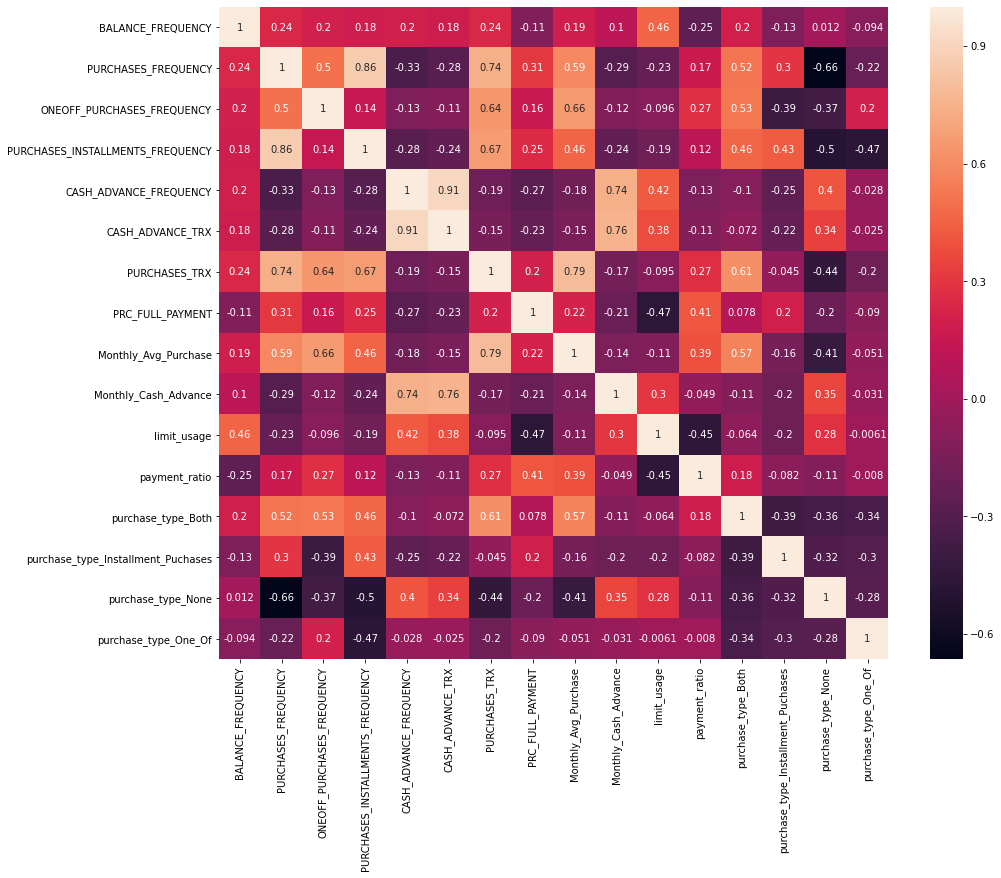

In [46]:
plt.figure(figsize = (15, 12))
sns.heatmap(credit_card_final.corr(),annot=True)
plt.show()

In [47]:
credit_card_final.columns

Index(['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'PRC_FULL_PAYMENT', 'Monthly_Avg_Purchase', 'Monthly_Cash_Advance',
       'limit_usage', 'payment_ratio', 'purchase_type_Both',
       'purchase_type_Installment_Puchases', 'purchase_type_None',
       'purchase_type_One_Of'],
      dtype='object')

In [48]:
pandas_profiling.ProfileReport(credit_card_final)

C:\Users\nanda\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,16
Number of observations,8950
Total Missing (%),0.0%
Total size in memory,874.1 KiB
Average record size in memory,100.0 B
Numeric,11
Categorical,0
Boolean,4
Date,0
Text (Unique),0
Rejected,1


#### Standardizing the Data

In [49]:
sc=StandardScaler()

credit_card_scaled=sc.fit_transform(credit_card_final)

In [50]:
pd.DataFrame(credit_card_scaled).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.297904,-0.806490,-0.678661,-0.707313,-0.722502,-0.636381,-0.680426,-0.525551,-0.672440,-0.600126,-0.990035,-5.939402e-01,-0.670193,1.720516,-0.543690,-0.514625
1,0.118296,-1.221758,-0.678661,-0.916995,0.692644,0.295454,-0.807798,0.234227,-0.757187,2.868023,0.212119,-1.666981e-01,-0.670193,-0.581221,1.839282,-0.514625
2,0.534496,1.269843,2.673451,-0.916995,-0.722502,-0.636381,-0.043563,-0.525551,-0.070357,-0.600126,-0.148038,-6.755970e-01,-0.670193,-0.581221,-0.543690,1.943162
3,-1.130304,-1.014125,-0.399319,-0.916995,-0.250789,-0.403422,-0.744112,-0.525551,0.574420,-0.460364,-0.466800,-1.435121e-14,-0.670193,-0.581221,-0.543690,1.943162
4,0.534496,-1.014125,-0.399319,-0.916995,-0.722502,-0.636381,-0.744112,-0.525551,-0.742974,-0.600126,0.858316,-3.561361e-01,-0.670193,-0.581221,-0.543690,1.943162
5,0.534496,0.439310,-0.678661,0.550784,-0.722502,-0.636381,-0.298308,-0.525551,0.427206,-0.600126,1.681497,-7.492201e-01,-0.670193,1.720516,-0.543690,-0.514625
6,0.534496,1.269843,2.673451,1.599199,-0.722502,-0.636381,2.822320,2.893453,2.859205,-0.600126,-0.973982,2.995248e+00,1.492109,-0.581221,-0.543690,-0.514625
7,0.534496,1.269843,-0.678661,1.599199,-0.722502,-0.636381,-0.043563,-0.525551,-0.369697,-0.600126,1.179964,-6.244882e-01,-0.670193,1.720516,-0.543690,-0.514625
8,0.534496,-0.391225,-0.399319,-0.287947,-0.722502,-0.636381,-0.489367,-0.525551,0.008101,-0.600126,-0.689670,-4.575357e-01,1.492109,-0.581221,-0.543690,-0.514625
9,-1.546504,-0.806490,-0.119974,-0.916995,-0.722502,-0.636381,-0.616739,-0.525551,0.381297,-0.600126,-1.068127,1.231216e+00,-0.670193,-0.581221,-0.543690,1.943162


In [51]:
pd.DataFrame(credit_card_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03
mean,-6.460754e-15,-3.716084e-16,2.021052e-15,2.353921e-16,9.352668e-16,-1.490087e-15,-2.098495e-15,-2.201566e-15,-3.022412e-15,-1.857800e-15,3.347540e-16,-3.853528e-16,-3.752852e-15,8.733374e-15,-4.507133e-16,-2.274580e-15
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00
min,-2.795108e+00,-1.221758e+00,-6.786608e-01,-9.169952e-01,-7.225024e-01,-6.363807e-01,-8.077983e-01,-5.255510e-01,-7.571870e-01,-6.001256e-01,-1.099570e+00,-7.720296e-01,-6.701925e-01,-5.812208e-01,-5.436904e-01,-5.146250e-01
25%,2.580728e-02,-1.014125e+00,-6.786608e-01,-9.169952e-01,-7.225024e-01,-6.363807e-01,-7.441120e-01,-5.255510e-01,-7.209497e-01,-6.001256e-01,-9.882121e-01,-6.786071e-01,-6.701925e-01,-5.812208e-01,-5.436904e-01,-5.146250e-01
50%,5.344962e-01,2.404259e-02,-3.993193e-01,-4.976286e-01,-7.225024e-01,-6.363807e-01,-3.619943e-01,-5.255510e-01,-4.167433e-01,-6.001256e-01,-2.337552e-01,-4.323495e-01,-6.701925e-01,-5.812208e-01,-5.436904e-01,-5.146250e-01
75%,5.344962e-01,1.062211e+00,3.269728e-01,9.701506e-01,5.354039e-01,2.954541e-01,2.748686e-01,-3.712234e-02,2.792633e-01,2.074019e-01,9.626118e-01,2.284218e-01,1.492109e+00,1.720516e+00,-5.436904e-01,-5.146250e-01
max,5.344962e-01,1.269843e+00,2.673451e+00,1.599199e+00,2.579503e+00,2.858000e+00,2.822320e+00,2.893453e+00,2.859205e+00,2.868023e+00,1.681497e+00,2.995248e+00,1.492109e+00,1.720516e+00,1.839282e+00,1.943162e+00


### PCA

In [52]:
pc = PCA(n_components=16)

In [53]:
pc.fit(credit_card_scaled)

PCA(n_components=16)

In [54]:
#Eigen Values
pc.explained_variance_

array([5.17768019e+00, 2.91939029e+00, 1.95032873e+00, 1.59137120e+00,
       1.14378727e+00, 7.86675111e-01, 5.75724969e-01, 4.10052899e-01,
       3.79352500e-01, 2.95902978e-01, 2.72156905e-01, 2.45028369e-01,
       1.37939175e-01, 8.07701272e-02, 3.56272046e-02, 1.61931843e-29])

In [55]:
sum(pc.explained_variance_)

16.001787909263577

In [56]:
#The amount of variance that each PC explains
var= pc.explained_variance_ratio_
var

array([3.23568855e-01, 1.82441506e-01, 1.21881926e-01, 9.94495872e-02,
       7.14787171e-02, 4.91617009e-02, 3.59787901e-02, 2.56254427e-02,
       2.37068821e-02, 1.84918697e-02, 1.70079060e-02, 1.53125620e-02,
       8.62023519e-03, 5.04756891e-03, 2.22645149e-03, 1.01196094e-30])

In [57]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pc.explained_variance_ratio_, decimals=4)*100)
var1

array([32.36, 50.6 , 62.79, 72.73, 79.88, 84.8 , 88.4 , 90.96, 93.33,
       95.18, 96.88, 98.41, 99.27, 99.77, 99.99, 99.99])

In [58]:
pd.DataFrame({'Eigen_value': pc.explained_variance_, 'Cumm_variance':var1}, index=range(1,17)).round(4)

,Eigen_value,Cumm_variance
1,5.1777,32.36
2,2.9194,50.60
3,1.9503,62.79
4,1.5914,72.73
5,1.1438,79.88
6,0.7867,84.80
7,0.5757,88.40
8,0.4101,90.96
9,0.3794,93.33
10,0.2959,95.18


#### We will choose 5 components as around 80% varaince is explained

In [59]:
pc_final=PCA(n_components=5).fit(credit_card_scaled)

In [60]:
pc_final.explained_variance_

array([5.17768019, 2.91939029, 1.95032873, 1.5913712 , 1.14378727])

In [61]:
reduced_cr=pc_final.fit_transform(credit_card_scaled)  # the output is Factors (F1, F2, ...F5)

In [62]:
dimensions = pd.DataFrame(reduced_cr)

In [63]:
dimensions.columns = ["C1", "C2", "C3", "C4", "C5"]

In [64]:
dimensions.head()

,C1,C2,C3,C4,C5
0,-0.566744,-2.354214,-0.843266,-0.350270,0.146086
1,-3.137647,0.729257,-0.009722,1.457984,-0.586741
2,0.931547,0.096652,1.986389,-2.346142,1.231538
3,-0.855834,-1.321930,2.056593,-0.775870,0.798522
4,-1.325502,-0.992627,1.198695,-2.201792,0.550644


#### Loading Matrix

Loadings=Eigenvectors * sqrt(Eigenvalues)

loadings are the covariances/correlations between the original variables and the unit-scaled components.

In [65]:
#pc_final.components_
Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=credit_card_final.columns).T

In [66]:
Loadings.to_csv("Loadings.csv")

In [67]:
Loadings

,0,1,2,3,4
BALANCE_FREQUENCY,0.069923,0.566450,-0.295281,-0.383800,-0.003903
PURCHASES_FREQUENCY,0.871041,0.172267,-0.283707,-0.020437,0.208612
ONEOFF_PURCHASES_FREQUENCY,0.582060,0.449080,0.490041,-0.142085,0.063332
PURCHASES_INSTALLMENTS_FREQUENCY,0.753812,0.099382,-0.560078,0.110164,0.051410
CASH_ADVANCE_FREQUENCY,-0.587987,0.632320,-0.087611,0.310265,0.229969
CASH_ADVANCE_TRX,-0.539453,0.637728,-0.092669,0.345990,0.285957
PURCHASES_TRX,0.799033,0.435857,-0.028620,0.017220,-0.006971
PRC_FULL_PAYMENT,0.441699,-0.260697,0.102926,0.485743,0.074543
Monthly_Avg_Purchase,0.730462,0.422793,0.210273,0.047916,0.003784
Monthly_Cash_Advance,-0.515578,0.545723,-0.056131,0.401514,0.253796


### Factor Analysis

In [68]:
credit_card_final.columns

Index(['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'PRC_FULL_PAYMENT', 'Monthly_Avg_Purchase', 'Monthly_Cash_Advance',
       'limit_usage', 'payment_ratio', 'purchase_type_Both',
       'purchase_type_Installment_Puchases', 'purchase_type_None',
       'purchase_type_One_Of'],
      dtype='object')

In [69]:
corrl=pd.DataFrame(credit_card_scaled).corr()
corrl

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.237081,0.204411,0.184918,0.200011,0.178447,0.240389,-0.111917,0.187511,0.103147,0.456759,-0.251432,0.195141,-0.130401,0.011554,-0.094483
1,0.237081,1.000000,0.501343,0.862934,-0.333006,-0.282215,0.742413,0.305802,0.589490,-0.288386,-0.227201,0.167603,0.515593,0.295918,-0.664037,-0.217147
2,0.204411,0.501343,1.000000,0.142329,-0.125492,-0.106483,0.638118,0.157531,0.656923,-0.124294,-0.096479,0.272245,0.525795,-0.394452,-0.368981,0.204113
3,0.184918,0.862934,0.142329,1.000000,-0.282139,-0.237355,0.667528,0.250087,0.457713,-0.240906,-0.185039,0.115500,0.463390,0.430024,-0.498338,-0.471909
4,0.200011,-0.333006,-0.125492,-0.282139,1.000000,0.914309,-0.193915,-0.267346,-0.182080,0.740138,0.422822,-0.132533,-0.104190,-0.252571,0.403497,-0.028043
5,0.178447,-0.282215,-0.106483,-0.237355,0.914309,1.000000,-0.153120,-0.233783,-0.147088,0.758293,0.380526,-0.113462,-0.071919,-0.224891,0.336294,-0.024967
6,0.240389,0.742413,0.638118,0.667528,-0.193915,-0.153120,1.000000,0.204168,0.792361,-0.170463,-0.094709,0.266097,0.614651,-0.045171,-0.439141,-0.197484
7,-0.111917,0.305802,0.157531,0.250087,-0.267346,-0.233783,0.204168,1.000000,0.217319,-0.209090,-0.467390,0.412222,0.078435,0.197362,-0.203263,-0.090251
8,0.187511,0.589490,0.656923,0.457713,-0.182080,-0.147088,0.792361,0.217319,1.000000,-0.137162,-0.113558,0.392991,0.569922,-0.161572,-0.411675,-0.050677
9,0.103147,-0.288386,-0.124294,-0.240906,0.740138,0.758293,-0.170463,-0.209090,-0.137162,1.000000,0.298660,-0.048753,-0.105306,-0.197426,0.350562,-0.031061


In [70]:
#Calculating Eigen value table using numpy
eigen_values = np.linalg.eigvals(corrl)
eigen_values_cumvar = (eigen_values/corrl.shape[0]).cumsum()
pd.DataFrame({'Eigen_value': eigen_values, 'Cumm_variance':eigen_values_cumvar}, index=range(1,17)).round(4)

,Eigen_value,Cumm_variance
1,5.1771,0.3236
2,2.9191,0.5060
3,1.9501,0.6279
4,1.5912,0.7273
5,1.1437,0.7988
6,0.7866,0.8480
7,0.5757,0.8840
8,0.0356,0.8862
9,0.0808,0.8912
10,0.1379,0.8999


#### We will take 5 factors as the eigen value is close to 1 and explains more than 75 % of variance.

In [71]:
fa = FactorAnalyzer(n_factors=5,rotation='varimax',method='ml').fit(credit_card_final)

### Loading Matrix

In [72]:
loadings_fa=pd.DataFrame(fa.loadings_,columns=["Fctr1","Fctr2","Fctr3","Fctr4","Fctr5"])
loadings_fa = loadings_fa.set_index(credit_card_final.columns)
loadings_fa

,Fctr1,Fctr2,Fctr3,Fctr4,Fctr5
BALANCE_FREQUENCY,0.349838,0.263093,-0.012612,0.050905,-0.061345
PURCHASES_FREQUENCY,0.806887,-0.226992,0.339868,0.135456,0.287715
ONEOFF_PURCHASES_FREQUENCY,0.700856,-0.077131,-0.299602,-0.206155,0.123086
PURCHASES_INSTALLMENTS_FREQUENCY,0.661941,-0.184741,0.432541,0.386178,0.217089
CASH_ADVANCE_FREQUENCY,-0.103246,0.930650,-0.056248,0.006650,-0.067316
CASH_ADVANCE_TRX,-0.070459,0.935001,-0.028350,0.003269,-0.006449
PURCHASES_TRX,0.860983,-0.101008,0.035323,0.137801,0.125253
PRC_FULL_PAYMENT,0.216614,-0.276396,0.174165,0.050650,-0.001154
Monthly_Avg_Purchase,0.755564,-0.109524,-0.092565,0.020388,0.142372
Monthly_Cash_Advance,-0.097425,0.775701,-0.033375,0.010007,-0.071724


In [73]:
#loadings_fa.to_excel('FA_Loadings.xlsx')

In [74]:
#selected the list variables based on factor loading matrics
list_var = ['CASH_ADVANCE_TRX','CASH_ADVANCE_FREQUENCY','limit_usage','PRC_FULL_PAYMENT','Monthly_Cash_Advance',
            'PURCHASES_FREQUENCY','BALANCE_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY',
            'Monthly_Avg_Purchase', 'payment_ratio','purchase_type_Installment_Puchases', 'purchase_type_One_Of','purchase_type_None']

#### Standardizing the Data

In [75]:
credit_card_scaled1=pd.DataFrame(credit_card_scaled, columns=credit_card_final.columns)
credit_card_scaled1.head(5)

credit_card_scaled2=credit_card_scaled1[list_var]
credit_card_scaled2.head(10)

,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,limit_usage,PRC_FULL_PAYMENT,Monthly_Cash_Advance,PURCHASES_FREQUENCY,BALANCE_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,Monthly_Avg_Purchase,payment_ratio,purchase_type_Installment_Puchases,purchase_type_One_Of,purchase_type_None
0,-0.636381,-0.722502,-0.990035,-0.525551,-0.600126,-0.806490,-0.297904,-0.678661,-0.707313,-0.672440,-5.939402e-01,1.720516,-0.514625,-0.543690
1,0.295454,0.692644,0.212119,0.234227,2.868023,-1.221758,0.118296,-0.678661,-0.916995,-0.757187,-1.666981e-01,-0.581221,-0.514625,1.839282
2,-0.636381,-0.722502,-0.148038,-0.525551,-0.600126,1.269843,0.534496,2.673451,-0.916995,-0.070357,-6.755970e-01,-0.581221,1.943162,-0.543690
3,-0.403422,-0.250789,-0.466800,-0.525551,-0.460364,-1.014125,-1.130304,-0.399319,-0.916995,0.574420,-1.435121e-14,-0.581221,1.943162,-0.543690
4,-0.636381,-0.722502,0.858316,-0.525551,-0.600126,-1.014125,0.534496,-0.399319,-0.916995,-0.742974,-3.561361e-01,-0.581221,1.943162,-0.543690
5,-0.636381,-0.722502,1.681497,-0.525551,-0.600126,0.439310,0.534496,-0.678661,0.550784,0.427206,-7.492201e-01,1.720516,-0.514625,-0.543690
6,-0.636381,-0.722502,-0.973982,2.893453,-0.600126,1.269843,0.534496,2.673451,1.599199,2.859205,2.995248e+00,-0.581221,-0.514625,-0.543690
7,-0.636381,-0.722502,1.179964,-0.525551,-0.600126,1.269843,0.534496,-0.678661,1.599199,-0.369697,-6.244882e-01,1.720516,-0.514625,-0.543690
8,-0.636381,-0.722502,-0.689670,-0.525551,-0.600126,-0.391225,0.534496,-0.399319,-0.287947,0.008101,-4.575357e-01,-0.581221,-0.514625,-0.543690
9,-0.636381,-0.722502,-1.068127,-0.525551,-0.600126,-0.806490,-1.546504,-0.119974,-0.916995,0.381297,1.231216e+00,-0.581221,1.943162,-0.543690


### Segmentation

#### 3 Cluster Solution

In [76]:
km_3=KMeans(n_clusters=3,random_state=123)
#KMeans?

In [77]:
km_3.fit(credit_card_scaled2)

KMeans(n_clusters=3, random_state=123)

In [78]:
km_3.labels_

array([1, 0, 2, ..., 1, 0, 2])

In [79]:
km_3.cluster_centers_

array([[ 0.96464921,  1.01110708,  0.57847396, -0.38721539,  0.89840041,
        -0.89358839,  0.12563555, -0.47096877, -0.69867028, -0.55531521,
        -0.21830279, -0.45882294, -0.31200226,  1.19293679],
       [-0.4684835 , -0.50343613, -0.32017171,  0.30066124, -0.43845031,
         0.71027309,  0.02786017,  0.13454067,  0.78180144,  0.37766564,
         0.13233129,  0.50701378, -0.514625  , -0.54369045],
       [-0.36314217, -0.3477598 , -0.11367637, -0.15298569, -0.33252367,
        -0.39663379, -0.28308169,  0.42717194, -0.91091462, -0.07741168,
         0.01237386, -0.58122082,  1.88474805, -0.54369045]])

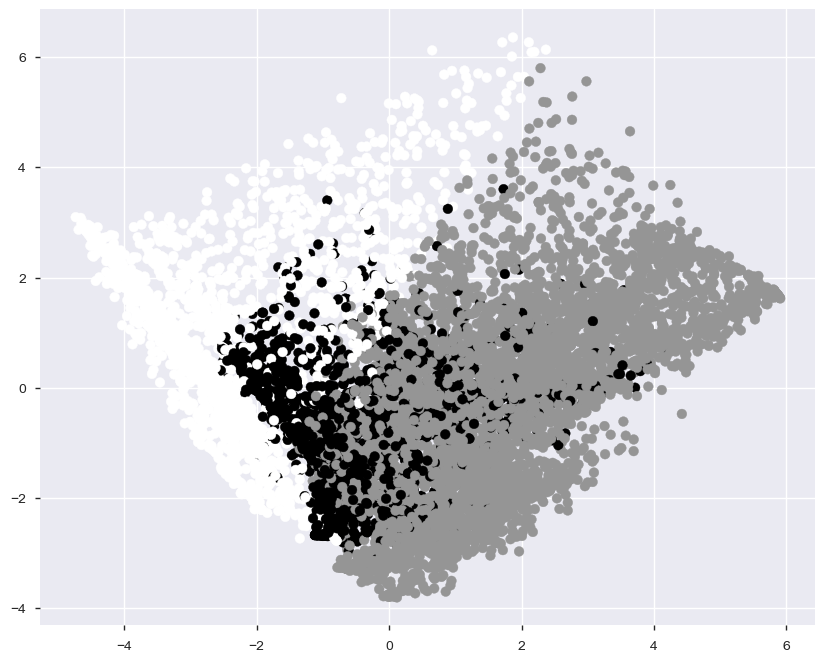

In [80]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_3.labels_.astype(float))

#### Clusters 4 to 8 

In [81]:
km_4=KMeans(n_clusters=4,random_state=123).fit(credit_card_scaled2)
#km_5.labels_a

km_5=KMeans(n_clusters=5,random_state=123).fit(credit_card_scaled2)
#km_5.labels_

km_6=KMeans(n_clusters=6,random_state=123).fit(credit_card_scaled2)
#km_6.labels_

km_7=KMeans(n_clusters=7,random_state=123).fit(credit_card_scaled2)
#km_7.labels_

km_8=KMeans(n_clusters=8,random_state=123).fit(credit_card_scaled2)
#km_5.labels_

In [82]:
credit_card_final['cluster_3'] = km_3.labels_
credit_card_final['cluster_4'] = km_4.labels_
credit_card_final['cluster_5'] = km_5.labels_
credit_card_final['cluster_6'] = km_6.labels_
credit_card_final['cluster_7'] = km_7.labels_
credit_card_final['cluster_8'] = km_8.labels_

In [83]:
credit_card_final.head(10)

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Cash_Advance,...,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,0.166667,0.000000,0.083333,0.000000,0,2,0.000000,7.950000,0.000000,...,0,1,0,0,1,1,2,1,2,1
1,0.909091,0.000000,0.000000,0.000000,0.250000,4,0,0.222222,0.000000,425.548562,...,0,0,1,0,0,2,4,3,5,5
2,1.000000,1.000000,1.000000,0.000000,0.000000,0,12,0.000000,64.430833,0.000000,...,0,0,0,1,2,3,0,5,0,2
3,0.636364,0.083333,0.083333,0.000000,0.083333,1,1,0.000000,124.916667,17.149001,...,0,0,0,1,2,3,0,5,0,2
4,1.000000,0.083333,0.083333,0.000000,0.000000,0,1,0.000000,1.333333,0.000000,...,0,0,0,1,2,3,0,5,0,2
5,1.000000,0.666667,0.000000,0.583333,0.000000,0,8,0.000000,111.106667,0.000000,...,0,1,0,0,1,1,2,0,2,1
6,1.000000,1.000000,1.000000,1.000000,0.000000,0,57,1.000000,339.250042,0.000000,...,1,0,0,0,1,0,1,2,1,3
7,1.000000,1.000000,0.000000,1.000000,0.000000,0,12,0.000000,36.350000,0.000000,...,0,1,0,0,1,1,2,0,2,1
8,1.000000,0.333333,0.083333,0.250000,0.000000,0,5,0.000000,71.790833,0.000000,...,1,0,0,0,1,3,0,0,6,4
9,0.545455,0.166667,0.166667,0.000000,0.000000,0,3,0.000000,106.800000,0.000000,...,0,0,0,1,2,3,0,5,4,6


In [84]:
pd.Series(km_3.labels_).value_counts()/sum(pd.Series(km_3.labels_).value_counts())

1    0.499106
0    0.312849
2    0.188045
dtype: float64

In [85]:
pd.Series(km_4.labels_).value_counts()/sum(pd.Series(km_4.labels_).value_counts())

2    0.299218
1    0.269162
0    0.225698
3    0.205922
dtype: float64

In [86]:
pd.Series(km_5.labels_).value_counts()/sum(pd.Series(km_5.labels_).value_counts())

2    0.265028
1    0.208827
0    0.205363
4    0.192067
3    0.128715
dtype: float64

In [87]:
pd.Series(km_6.labels_).value_counts()/sum(pd.Series(km_6.labels_).value_counts())

1    0.190503
3    0.188380
0    0.188156
5    0.171620
2    0.142458
4    0.118883
dtype: float64

In [88]:
pd.Series(km_7.labels_).value_counts()/sum(pd.Series(km_7.labels_).value_counts())

2    0.203464
6    0.179330
5    0.171732
0    0.130950
3    0.115084
4    0.113631
1    0.085810
dtype: float64

### Choosing number of clusters using Silhouette Coefficient

In [89]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(credit_card_scaled2, km_3.labels_)

0.23389763322214657

In [90]:
# calculate SC for K=3 through K=12
k_range = range(3,9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(credit_card_scaled2)
    scores.append(metrics.silhouette_score(credit_card_scaled2, km.labels_))

In [91]:
scores

[0.23389763322214657,
 0.24258585510352526,
 0.2526501612854466,
 0.23849993744169698,
 0.25247002132106877,
 0.2494746254680707]

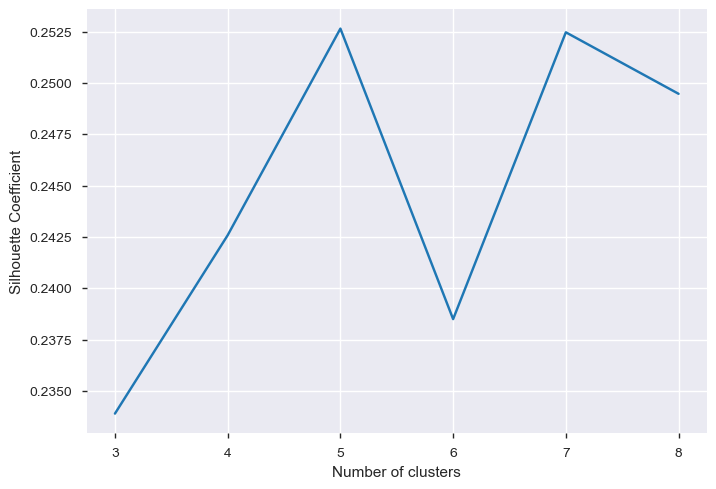

In [92]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Note

The solution can be 5 based on the SC score. If we take highest SC score, 5 segment solution is best

### Elbow Analysis

In [93]:
cluster_range = range( 2, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( credit_card_scaled2 )
    cluster_errors.append( clusters.inertia_ )

In [94]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,2,96082.212817
1,3,82996.718402
2,4,71123.513462
3,5,62926.954515
4,6,57430.560104
5,7,52558.966728
6,8,49436.023605
7,9,46345.140200
8,10,43864.991865
9,11,41604.476025


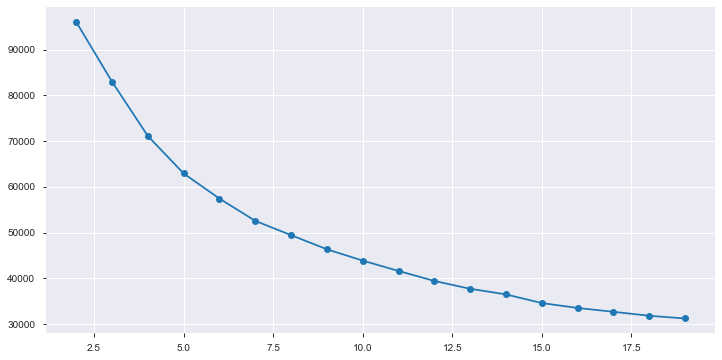

In [95]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

### Profiling

In [96]:
credit_card_final.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Cash_Advance,...,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,0.166667,0.000000,0.083333,0.000000,0,2,0.000000,7.950000,0.000000,...,0,1,0,0,1,1,2,1,2,1
1,0.909091,0.000000,0.000000,0.000000,0.250000,4,0,0.222222,0.000000,425.548562,...,0,0,1,0,0,2,4,3,5,5
2,1.000000,1.000000,1.000000,0.000000,0.000000,0,12,0.000000,64.430833,0.000000,...,0,0,0,1,2,3,0,5,0,2
3,0.636364,0.083333,0.083333,0.000000,0.083333,1,1,0.000000,124.916667,17.149001,...,0,0,0,1,2,3,0,5,0,2
4,1.000000,0.083333,0.083333,0.000000,0.000000,0,1,0.000000,1.333333,0.000000,...,0,0,0,1,2,3,0,5,0,2


In [97]:
credit_card_final.cluster_3.value_counts()*100/sum(credit_card_final.cluster_3.value_counts())

1    49.910615
0    31.284916
2    18.804469
Name: cluster_3, dtype: float64

In [98]:
pd.Series.sort_index(credit_card_final.cluster_5.value_counts())

0    1838
1    1869
2    2372
3    1152
4    1719
Name: cluster_5, dtype: int64

In [99]:
C5=pd.concat([credit_card_scaled2,pd.Series(km_5.labels_,name='cluster_5')],axis=1)

In [100]:
# Mean value of each variable group by Cluster 5
cluster_5_output=C5.groupby('cluster_5').apply(lambda x: x[list_var].mean()).T
cluster_5_output

cluster_5,0,1,2,3,4
CASH_ADVANCE_TRX,-0.404563,-0.441812,-0.537285,2.069742,0.267266
CASH_ADVANCE_FREQUENCY,-0.395364,-0.463689,-0.583181,1.894907,0.461713
limit_usage,-0.070761,-0.263416,-0.425324,0.667267,0.501781
PRC_FULL_PAYMENT,-0.279303,0.361513,0.391781,-0.391845,-0.372430
Monthly_Cash_Advance,-0.388745,-0.426896,-0.487646,1.781058,0.359104
PURCHASES_FREQUENCY,-0.447450,1.038678,0.535665,-0.258133,-1.217047
BALANCE_FREQUENCY,-0.273930,0.395519,-0.257667,0.378768,-0.035427
ONEOFF_PURCHASES_FREQUENCY,0.245666,1.234795,-0.637987,-0.071385,-0.677036
PURCHASES_INSTALLMENTS_FREQUENCY,-0.816090,0.844910,0.757189,-0.264740,-0.913458
Monthly_Avg_Purchase,-0.200502,1.353288,-0.287381,-0.156259,-0.755727


In [101]:
size=pd.concat([pd.Series(credit_card_final.cluster_3.size), pd.Series.sort_index(credit_card_final.cluster_3.value_counts()), pd.Series.sort_index(credit_card_final.cluster_4.value_counts()),
           pd.Series.sort_index(credit_card_final.cluster_5.value_counts()), pd.Series.sort_index(credit_card_final.cluster_6.value_counts()),
           pd.Series.sort_index(credit_card_final.cluster_7.value_counts()), pd.Series.sort_index(credit_card_final.cluster_8.value_counts())])

In [102]:
size

0    8950
0    2800
1    4467
2    1683
0    2020
1    2409
2    2678
3    1843
0    1838
1    1869
2    2372
3    1152
4    1719
0    1684
1    1705
2    1275
3    1686
4    1064
5    1536
0    1172
1     768
2    1821
3    1030
4    1017
5    1537
6    1605
0    1002
1    1055
2    1165
3     719
4    1592
5    1507
6     945
7     965
dtype: int64

In [103]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/credit_card_final.cluster_3.size, columns=['Seg_Pct'])

In [104]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.312849,0.499106,0.188045,0.225698,0.269162,0.299218,0.205922,0.205363,0.208827,...,0.171732,0.17933,0.111955,0.117877,0.130168,0.080335,0.177877,0.16838,0.105587,0.107821


In [105]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,2800.000000,4467.000000,1683.000000,2020.000000,2409.000000,2678.000000,1843.000000,1838.000000,1869.000000,...,1537.000000,1605.00000,1002.000000,1055.000000,1165.000000,719.000000,1592.000000,1507.00000,945.000000,965.000000
Seg_Pct,1.0,0.312849,0.499106,0.188045,0.225698,0.269162,0.299218,0.205922,0.205363,0.208827,...,0.171732,0.17933,0.111955,0.117877,0.130168,0.080335,0.177877,0.16838,0.105587,0.107821


In [106]:
credit_card_final.head(10)

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Cash_Advance,...,purchase_type_Both,purchase_type_Installment_Puchases,purchase_type_None,purchase_type_One_Of,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,0.166667,0.000000,0.083333,0.000000,0,2,0.000000,7.950000,0.000000,...,0,1,0,0,1,1,2,1,2,1
1,0.909091,0.000000,0.000000,0.000000,0.250000,4,0,0.222222,0.000000,425.548562,...,0,0,1,0,0,2,4,3,5,5
2,1.000000,1.000000,1.000000,0.000000,0.000000,0,12,0.000000,64.430833,0.000000,...,0,0,0,1,2,3,0,5,0,2
3,0.636364,0.083333,0.083333,0.000000,0.083333,1,1,0.000000,124.916667,17.149001,...,0,0,0,1,2,3,0,5,0,2
4,1.000000,0.083333,0.083333,0.000000,0.000000,0,1,0.000000,1.333333,0.000000,...,0,0,0,1,2,3,0,5,0,2
5,1.000000,0.666667,0.000000,0.583333,0.000000,0,8,0.000000,111.106667,0.000000,...,0,1,0,0,1,1,2,0,2,1
6,1.000000,1.000000,1.000000,1.000000,0.000000,0,57,1.000000,339.250042,0.000000,...,1,0,0,0,1,0,1,2,1,3
7,1.000000,1.000000,0.000000,1.000000,0.000000,0,12,0.000000,36.350000,0.000000,...,0,1,0,0,1,1,2,0,2,1
8,1.000000,0.333333,0.083333,0.250000,0.000000,0,5,0.000000,71.790833,0.000000,...,1,0,0,0,1,3,0,0,6,4
9,0.545455,0.166667,0.166667,0.000000,0.000000,0,3,0.000000,106.800000,0.000000,...,0,0,0,1,2,3,0,5,4,6


In [107]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([credit_card_final.apply(lambda x: x.mean()).T, credit_card_final.groupby('cluster_3').apply(lambda x: x.mean()).T, credit_card_final.groupby('cluster_4').apply(lambda x: x.mean()).T,
        credit_card_final.groupby('cluster_5').apply(lambda x: x.mean()).T, credit_card_final.groupby('cluster_6').apply(lambda x: x.mean()).T,
          credit_card_final.groupby('cluster_7').apply(lambda x: x.mean()).T, credit_card_final.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [108]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
BALANCE_FREQUENCY,0.883252,0.910630,0.889387,0.821420,0.970134,0.827406,0.907948,0.825138,0.823419,0.969644,...,0.942977,0.981114,0.960918,0.969778,0.953547,0.951936,0.981945,0.948708,0.386127,0.793758
PURCHASES_FREQUENCY,0.490351,0.131507,0.775182,0.331360,0.904389,0.706680,0.106427,0.311647,0.310767,0.907222,...,0.002006,0.807153,0.343430,0.706658,0.335263,0.919249,0.806477,0.001714,0.189050,0.810704
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.061705,0.242578,0.330139,0.560601,0.012067,0.046409,0.285529,0.275745,0.570821,...,0.000813,0.385372,0.173385,0.000000,0.334619,0.741090,0.391355,0.000829,0.082616,0.013711
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.086830,0.674880,0.002318,0.705014,0.665618,0.066907,0.029807,0.040102,0.700226,...,0.001247,0.658235,0.223062,0.675786,0.000715,0.616586,0.656150,0.000995,0.105412,0.762060
CASH_ADVANCE_FREQUENCY,0.127637,0.306181,0.038683,0.066697,0.072075,0.028515,0.301759,0.065089,0.057792,0.045722,...,0.221181,0.063518,0.484049,0.058388,0.081347,0.026987,0.067306,0.220670,0.041180,0.003059
CASH_ADVANCE_TRX,2.731732,6.872500,0.720394,1.181224,1.512376,0.520548,6.727409,1.152469,0.995103,0.835206,...,4.120364,1.183801,12.317365,1.082464,1.397425,0.515994,1.263191,4.106835,0.766138,0.043523
PURCHASES_TRX,12.684022,3.314643,20.726214,6.926322,33.721782,11.657949,2.306572,6.046120,6.050598,33.694489,...,0.031230,26.000000,9.162675,12.426540,6.645494,36.776078,26.079146,0.026543,3.251852,12.866321
PRC_FULL_PAYMENT,0.153715,0.040490,0.241545,0.108969,0.239849,0.266733,0.040634,0.075896,0.072023,0.259451,...,0.020128,0.041914,0.042457,0.022480,0.040947,0.603482,0.035434,0.018832,0.169948,0.603614
Monthly_Avg_Purchase,71.030929,18.923572,106.432021,63.760534,197.171124,44.592835,12.571194,52.279626,52.222057,197.981446,...,0.180344,137.336228,53.362264,44.405605,57.131604,239.349480,137.401858,0.167221,27.818197,53.342349
Monthly_Cash_Advance,73.636578,183.845372,19.828990,33.098178,38.134054,17.356374,179.874773,31.741961,25.936759,21.255588,...,119.201841,29.140800,310.081602,35.215700,36.985866,12.653513,30.557554,117.942555,32.408142,2.066199


In [109]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [110]:
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.000000,2800.000000,4467.000000,1683.000000,2020.000000,2409.000000,2678.000000,1843.000000,1838.000000,1869.000000,...,1537.000000,1605.000000,1002.000000,1055.000000,1165.000000,719.000000,1592.000000,1507.000000,945.000000,965.000000
Seg_Pct,1.000000,0.312849,0.499106,0.188045,0.225698,0.269162,0.299218,0.205922,0.205363,0.208827,...,0.171732,0.179330,0.111955,0.117877,0.130168,0.080335,0.177877,0.168380,0.105587,0.107821
BALANCE_FREQUENCY,0.883252,0.910630,0.889387,0.821420,0.970134,0.827406,0.907948,0.825138,0.823419,0.969644,...,0.942977,0.981114,0.960918,0.969778,0.953547,0.951936,0.981945,0.948708,0.386127,0.793758
PURCHASES_FREQUENCY,0.490351,0.131507,0.775182,0.331360,0.904389,0.706680,0.106427,0.311647,0.310767,0.907222,...,0.002006,0.807153,0.343430,0.706658,0.335263,0.919249,0.806477,0.001714,0.189050,0.810704
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.061705,0.242578,0.330139,0.560601,0.012067,0.046409,0.285529,0.275745,0.570821,...,0.000813,0.385372,0.173385,0.000000,0.334619,0.741090,0.391355,0.000829,0.082616,0.013711
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.086830,0.674880,0.002318,0.705014,0.665618,0.066907,0.029807,0.040102,0.700226,...,0.001247,0.658235,0.223062,0.675786,0.000715,0.616586,0.656150,0.000995,0.105412,0.762060
CASH_ADVANCE_FREQUENCY,0.127637,0.306181,0.038683,0.066697,0.072075,0.028515,0.301759,0.065089,0.057792,0.045722,...,0.221181,0.063518,0.484049,0.058388,0.081347,0.026987,0.067306,0.220670,0.041180,0.003059
CASH_ADVANCE_TRX,2.731732,6.872500,0.720394,1.181224,1.512376,0.520548,6.727409,1.152469,0.995103,0.835206,...,4.120364,1.183801,12.317365,1.082464,1.397425,0.515994,1.263191,4.106835,0.766138,0.043523
PURCHASES_TRX,12.684022,3.314643,20.726214,6.926322,33.721782,11.657949,2.306572,6.046120,6.050598,33.694489,...,0.031230,26.000000,9.162675,12.426540,6.645494,36.776078,26.079146,0.026543,3.251852,12.866321
PRC_FULL_PAYMENT,0.153715,0.040490,0.241545,0.108969,0.239849,0.266733,0.040634,0.075896,0.072023,0.259451,...,0.020128,0.041914,0.042457,0.022480,0.040947,0.603482,0.035434,0.018832,0.169948,0.603614


In [111]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [112]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,2800.000000,4467.000000,1683.000000,2020.000000,2409.000000,2678.000000,1843.000000,1838.000000,1869.000000,...,1537.000000,1605.000000,1002.000000,1055.000000,1165.000000,719.000000,1592.000000,1507.000000,945.000000,965.000000
Seg_Pct,1.000000,0.312849,0.499106,0.188045,0.225698,0.269162,0.299218,0.205922,0.205363,0.208827,...,0.171732,0.179330,0.111955,0.117877,0.130168,0.080335,0.177877,0.168380,0.105587,0.107821
BALANCE_FREQUENCY,0.883252,0.910630,0.889387,0.821420,0.970134,0.827406,0.907948,0.825138,0.823419,0.969644,...,0.942977,0.981114,0.960918,0.969778,0.953547,0.951936,0.981945,0.948708,0.386127,0.793758
PURCHASES_FREQUENCY,0.490351,0.131507,0.775182,0.331360,0.904389,0.706680,0.106427,0.311647,0.310767,0.907222,...,0.002006,0.807153,0.343430,0.706658,0.335263,0.919249,0.806477,0.001714,0.189050,0.810704
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.061705,0.242578,0.330139,0.560601,0.012067,0.046409,0.285529,0.275745,0.570821,...,0.000813,0.385372,0.173385,0.000000,0.334619,0.741090,0.391355,0.000829,0.082616,0.013711
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.086830,0.674880,0.002318,0.705014,0.665618,0.066907,0.029807,0.040102,0.700226,...,0.001247,0.658235,0.223062,0.675786,0.000715,0.616586,0.656150,0.000995,0.105412,0.762060
CASH_ADVANCE_FREQUENCY,0.127637,0.306181,0.038683,0.066697,0.072075,0.028515,0.301759,0.065089,0.057792,0.045722,...,0.221181,0.063518,0.484049,0.058388,0.081347,0.026987,0.067306,0.220670,0.041180,0.003059
CASH_ADVANCE_TRX,2.731732,6.872500,0.720394,1.181224,1.512376,0.520548,6.727409,1.152469,0.995103,0.835206,...,4.120364,1.183801,12.317365,1.082464,1.397425,0.515994,1.263191,4.106835,0.766138,0.043523
PURCHASES_TRX,12.684022,3.314643,20.726214,6.926322,33.721782,11.657949,2.306572,6.046120,6.050598,33.694489,...,0.031230,26.000000,9.162675,12.426540,6.645494,36.776078,26.079146,0.026543,3.251852,12.866321
PRC_FULL_PAYMENT,0.153715,0.040490,0.241545,0.108969,0.239849,0.266733,0.040634,0.075896,0.072023,0.259451,...,0.020128,0.041914,0.042457,0.022480,0.040947,0.603482,0.035434,0.018832,0.169948,0.603614


In [113]:
#Profling_output_final.to_csv('Profiling.csv')

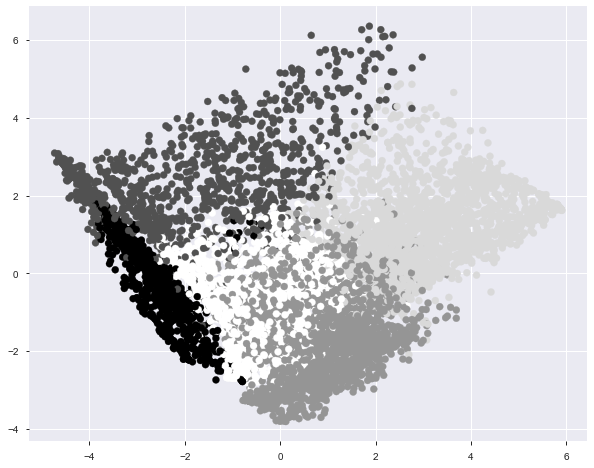

In [114]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_5.labels_.astype(float))

In [115]:
credit_card_scaled2.head()

,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,limit_usage,PRC_FULL_PAYMENT,Monthly_Cash_Advance,PURCHASES_FREQUENCY,BALANCE_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,Monthly_Avg_Purchase,payment_ratio,purchase_type_Installment_Puchases,purchase_type_One_Of,purchase_type_None
0,-0.636381,-0.722502,-0.990035,-0.525551,-0.600126,-0.806490,-0.297904,-0.678661,-0.707313,-0.672440,-5.939402e-01,1.720516,-0.514625,-0.543690
1,0.295454,0.692644,0.212119,0.234227,2.868023,-1.221758,0.118296,-0.678661,-0.916995,-0.757187,-1.666981e-01,-0.581221,-0.514625,1.839282
2,-0.636381,-0.722502,-0.148038,-0.525551,-0.600126,1.269843,0.534496,2.673451,-0.916995,-0.070357,-6.755970e-01,-0.581221,1.943162,-0.543690
3,-0.403422,-0.250789,-0.466800,-0.525551,-0.460364,-1.014125,-1.130304,-0.399319,-0.916995,0.574420,-1.435121e-14,-0.581221,1.943162,-0.543690
4,-0.636381,-0.722502,0.858316,-0.525551,-0.600126,-1.014125,0.534496,-0.399319,-0.916995,-0.742974,-3.561361e-01,-0.581221,1.943162,-0.543690


In [116]:
centroids = km_5.cluster_centers_
centroids

array([[-0.4040554 , -0.39502874, -0.07070352, -0.27943691, -0.38834688,
        -0.44696764, -0.27349006,  0.24561896, -0.8155752 , -0.20016155,
        -0.11064247, -0.58122082,  1.49677803, -0.54369045],
       [-0.44191519, -0.46350078, -0.26300208,  0.36372604, -0.42693807,
         1.0395065 ,  0.3951467 ,  1.23812934,  0.84524929,  1.35742724,
         0.61634098, -0.57134212, -0.38540656, -0.54369045],
       [-0.53745171, -0.58341522, -0.42550215,  0.39036702, -0.48783492,
         0.53611418, -0.25633322, -0.63699761,  0.75737081, -0.28747601,
        -0.15278317,  1.45992418, -0.514625  , -0.54369045],
       [ 2.06974206,  1.89490657,  0.66726681, -0.39184472,  1.78105796,
        -0.25813326,  0.37876815, -0.07138498, -0.26474043, -0.1562589 ,
        -0.20382082, -0.29150562,  0.06355244,  0.14513749],
       [ 0.26726597,  0.4617135 ,  0.50178091, -0.37243036,  0.35910383,
        -1.21704735, -0.03542664, -0.67703578, -0.91345779, -0.75572661,
        -0.20219529, -0.58

In [117]:
km_5.predict(credit_card_scaled2)

array([2, 4, 0, ..., 2, 4, 0])

In [118]:
credit_card_scaled2['pred_segment'] = pd.Series(km_5.predict(credit_card_scaled2))

C:\Users\nanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [119]:
credit_card_scaled2.head(10)

,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,limit_usage,PRC_FULL_PAYMENT,Monthly_Cash_Advance,PURCHASES_FREQUENCY,BALANCE_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,Monthly_Avg_Purchase,payment_ratio,purchase_type_Installment_Puchases,purchase_type_One_Of,purchase_type_None,pred_segment
0,-0.636381,-0.722502,-0.990035,-0.525551,-0.600126,-0.806490,-0.297904,-0.678661,-0.707313,-0.672440,-5.939402e-01,1.720516,-0.514625,-0.543690,2
1,0.295454,0.692644,0.212119,0.234227,2.868023,-1.221758,0.118296,-0.678661,-0.916995,-0.757187,-1.666981e-01,-0.581221,-0.514625,1.839282,4
2,-0.636381,-0.722502,-0.148038,-0.525551,-0.600126,1.269843,0.534496,2.673451,-0.916995,-0.070357,-6.755970e-01,-0.581221,1.943162,-0.543690,0
3,-0.403422,-0.250789,-0.466800,-0.525551,-0.460364,-1.014125,-1.130304,-0.399319,-0.916995,0.574420,-1.435121e-14,-0.581221,1.943162,-0.543690,0
4,-0.636381,-0.722502,0.858316,-0.525551,-0.600126,-1.014125,0.534496,-0.399319,-0.916995,-0.742974,-3.561361e-01,-0.581221,1.943162,-0.543690,0
5,-0.636381,-0.722502,1.681497,-0.525551,-0.600126,0.439310,0.534496,-0.678661,0.550784,0.427206,-7.492201e-01,1.720516,-0.514625,-0.543690,2
6,-0.636381,-0.722502,-0.973982,2.893453,-0.600126,1.269843,0.534496,2.673451,1.599199,2.859205,2.995248e+00,-0.581221,-0.514625,-0.543690,1
7,-0.636381,-0.722502,1.179964,-0.525551,-0.600126,1.269843,0.534496,-0.678661,1.599199,-0.369697,-6.244882e-01,1.720516,-0.514625,-0.543690,2
8,-0.636381,-0.722502,-0.689670,-0.525551,-0.600126,-0.391225,0.534496,-0.399319,-0.287947,0.008101,-4.575357e-01,-0.581221,-0.514625,-0.543690,0
9,-0.636381,-0.722502,-1.068127,-0.525551,-0.600126,-0.806490,-1.546504,-0.119974,-0.916995,0.381297,1.231216e+00,-0.581221,1.943162,-0.543690,0


### Based on Silhoutee coeficient and profiling we chose 5 clusters solution

### Assigning segments to new customer(Predicting segment for new data)

In [120]:
#new_customer = pd.read_csv('New_Customer_Data.csv')

In [121]:
#new_customer_scaled=sc.transform(new_customer)

In [122]:
#For the selected variables we will assign the new values based on the centroids values for selected 5 cluster solution
#centroids = km_5.cluster_centers_
#centroids
def kmeans_assignment(centroids, points):
    num_centroids, dim = centroids.shape
    num_points, _ = points.shape

  # Tile and reshape both arrays into `[num_points, num_centroids, dim]`.
    centroids = np.tile(centroids, [num_points, 1]).reshape([num_points, num_centroids, dim]) #(5x12)x100rows - 100,5,12
    points = np.tile(points, [1, num_centroids]).reshape([num_points, num_centroids, dim])    #(100x12)x5columns - 100,5,12

  # Compute all distances (for all points and all centroids) at once and 
  # select the min centroid for each point.
    distances = np.sqrt(np.sum(np.square(centroids - points), axis=2))
    return np.argmin(distances, axis=1)


In [123]:
#We will create tile of the values as:
#centroids
#np.tile(centroids, [2,2])

#And then we will assign the values
#kmeans_assignment(centroids, points)